In [3]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import random

%matplotlib inline

In [4]:
# Always reset the pseudo random number generator to the same number.
seed = 1012019
np.random.seed(seed)
random.seed(seed)

In [5]:
# Define the number of examples.
N = 1000

# Features.
x1 = 3.0 * np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [6]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-12.0, 14.0, M)
a2 = np.linspace(-12.0, 14.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
        J[iter1][iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

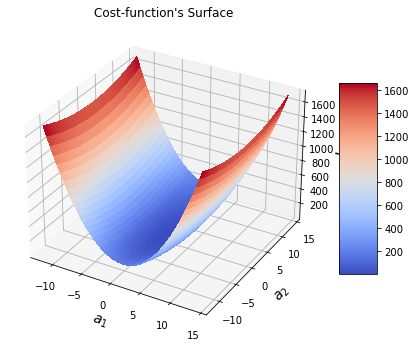

In [7]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
plt.savefig("error_surface_sgd_vs_mom.png", dpi=600)
#Show the plot.
plt.show()

In [8]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

yhat = X.dot(a_opt)
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

print('Joptimum:',Joptimum)

Joptimum: 0.9692215285411726


In [9]:
# learning schedule: Decaimento temporal
def timeBasedDecay(alpha_int, k, t):
    return alpha_int / (1 + k*t)

# learning schedule: Exponential Decay.
def exponentialDecay(alpha_int, k, t):
    return alpha_int * np.exp(-k*t)

def stepDecay(alpha_int, t, drop=0.5, epochs_drop = 4.0):
    alpha = alpha_int * math.pow(drop, math.floor((1+t)/epochs_drop))
    return alpha

k = 0.01
def learning_schedule(typels, alpha_int, k, t, mu=0.9):
    if(typels=='exp'):
        mom = 0.0
        alpha = exponentialDecay(alpha_int, k, t)
    elif(typels=='time'):
        mom = 0.0
        alpha = timeBasedDecay(alpha_int, k, t)
    elif(typels=='step'):
        mom = 0.0
        alpha = stepDecay(alpha_int, t)
    elif(typels=='mom'):
        mom = mu
        alpha = alpha_int
    elif(typels=='momstep'):
        mom = mu
        alpha = stepDecay(alpha_int, t)
    else:
        mom = 0.0
        alpha = alpha_int
    return alpha, mom

def sgd(X, y_noisy, n_epochs, typels, alpha_init, k, mu, seed):
    # reset pseudo-random generator.
    random.seed(seed)
    
    # Number of examples.
    N = len(y_noisy)
    
    # Random initialization of parameters.
    a = np.array([-10.0, -10.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*N+1))

    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create vector to store eta history.
    alpha_hist = np.zeros((n_epochs*N))

    # Momentum term.
    v = np.zeros((2, 1))

    # Create array for storing error values.
    Jgd = np.zeros(n_epochs*N+1)

    Jgd[0] = (1.0/N)*sum(np.power(y_noisy - X.dot(a), 2))

    update_hist = np.zeros((2, n_epochs*N))

    # Stocastic gradient-descent loop.
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_indexes = random.sample(range(0, N), N)  

        for i in range(N):
            random_index = shuffled_indexes[i]
            xi = X[random_index:random_index+1]
            yi = y_noisy[random_index:random_index+1]

            alpha, mu = learning_schedule(typels, alpha_init, k, (epoch*N + i), mu)
            
            gradient = -2.0*xi.T.dot(yi - xi.dot(a))      
            v = mu*v - alpha*gradient
            a = a + v

            a_hist[:, epoch*N+i+1] = a.reshape(2,)
            update_hist[:, epoch*N+i] = v.reshape(2,)
            alpha_hist[epoch*N+i] = alpha

            Jgd[epoch*N+i+1] = (1.0/N)*sum(np.power((y_noisy - X.dot(a)), 2))

    return a, Jgd, a_hist, update_hist, alpha_hist

# SGD Puro (sem momentum)

In [10]:
# Number of epochs.
n_epochs = 1
# Constant learning rate.
alpha_sgd = 0.02

a_sgd, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'none', alpha_sgd, k, 0.0, seed)

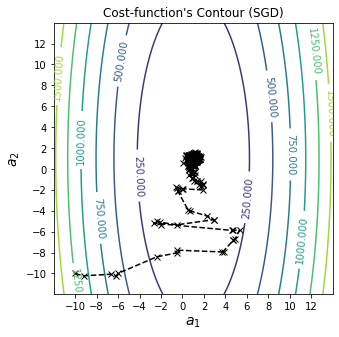

In [11]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (SGD)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 14, step=2.0))
plt.yticks(np.arange(-10, 14, step=2.0))
plt.savefig("error_contour_pure_sgd.png", dpi=600)
plt.show()

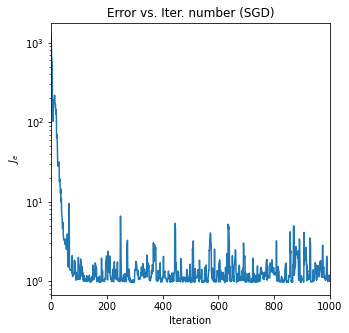

In [12]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, n_epochs*N), Jgd[0:n_epochs*N])
plt.xlim((0, n_epochs*N))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iter. number (SGD)')
plt.savefig("error_vs_iteration_pure_sgd.png", dpi=600)
plt.show()

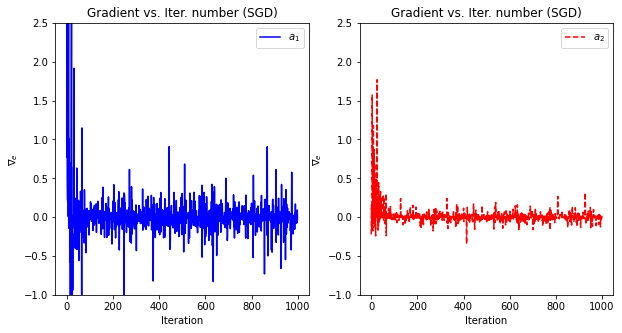

In [13]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (SGD)')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (SGD)')
ax2.legend()

plt.savefig("update_pure_sgd.png", dpi=600)
plt.show()

In [14]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.1476359847840465
var a2: 0.01250255881991285


# Momentum

In [15]:
# Number of epochs.
n_epochs = 1
# Constant learning rate.
alpha_mom = 0.001
# Coefficient of momentum.
mu = 0.9

a_mom, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'mom', alpha_mom, k, mu, seed)

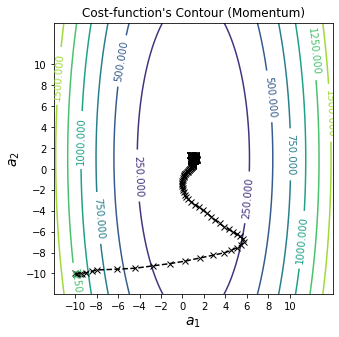

In [16]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (Momentum)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 12, step=2.0))
plt.yticks(np.arange(-10, 12, step=2.0))
plt.savefig("error_contour_mom.png", dpi=600)
plt.show()

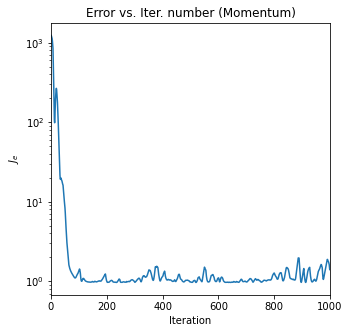

In [17]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, n_epochs*N), Jgd[0:n_epochs*N])
plt.xlim((0, n_epochs*N))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iter. number (Momentum)')
plt.savefig("error_vs_iteration_mom.png", dpi=600)
plt.show()

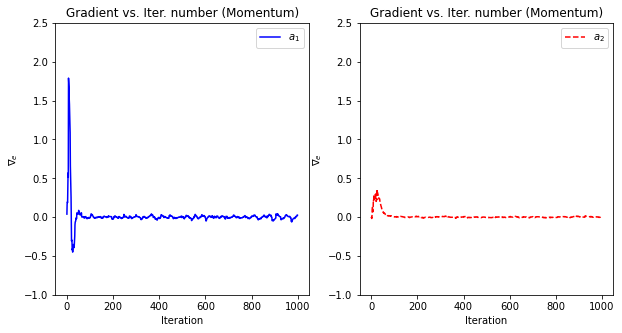

In [18]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (Momentum)')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (Momentum)')
ax2.legend()

plt.savefig("update_pure_mom.png", dpi=600)
plt.show()

In [19]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.021820157269152842
var a2: 0.0022069328383552424
